# **Project #11 - Visual Inspection of Motorcycle Connecting Rods**
### 91277 - Project Work in Image Processing and Computer Vision - A.Y. 2021-2022
Student:

- Giuseppe  Murro   (0000997317 $-$ giuseppe.murro@studio.unibo.it)


This software system aims at visual inspection of motorcycle connecting rods. The system should be able to analyse the dimensions of two different types of connecting rods to allow a vision-guided robot to pick and sort rods based on their type and dimensions. The two rod types are characterized by a different number of holes: Type A rods have one hole whilst Type B rods have two holes.

Import of all the libraries that will be used in the project:

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
from scipy.spatial import distance as dist

Prepare dictionaries that will be used to store intermediate and final processing

In [2]:
folder_path = os.path.join(os.getcwd(), "images")

# all image processings will be stored into a dictionary
first_task = dict.fromkeys(["Tesi00.bmp", "Tesi01.bmp", "Tesi12.bmp", "Tesi21.bmp", "Tesi31.bmp", "Tesi33.bmp"], None)
second_task_1 = dict.fromkeys(["Tesi44.bmp", "Tesi47.bmp", "Tesi48.bmp"], None)
second_task_2 = dict.fromkeys(["Tesi49.bmp", "Tesi50.bmp","Tesi51.bmp."], None)
second_task_3 = dict.fromkeys(["Tesi90.bmp","Tesi92.bmp","Tesi98.bmp"], None)

def load_image(path, image):
    """
    Load image from path
    """
    img = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
    return img

## First task
Images contain only connecting rods, which can be of both types and feature significantly diverse dimensions.
Images have been taken by the backlighting technique so to render rods easily distinguishable (i.e. much darker) from background. However, for flexibility reasons the system should not require any change to work properly with lighting sources of different power.

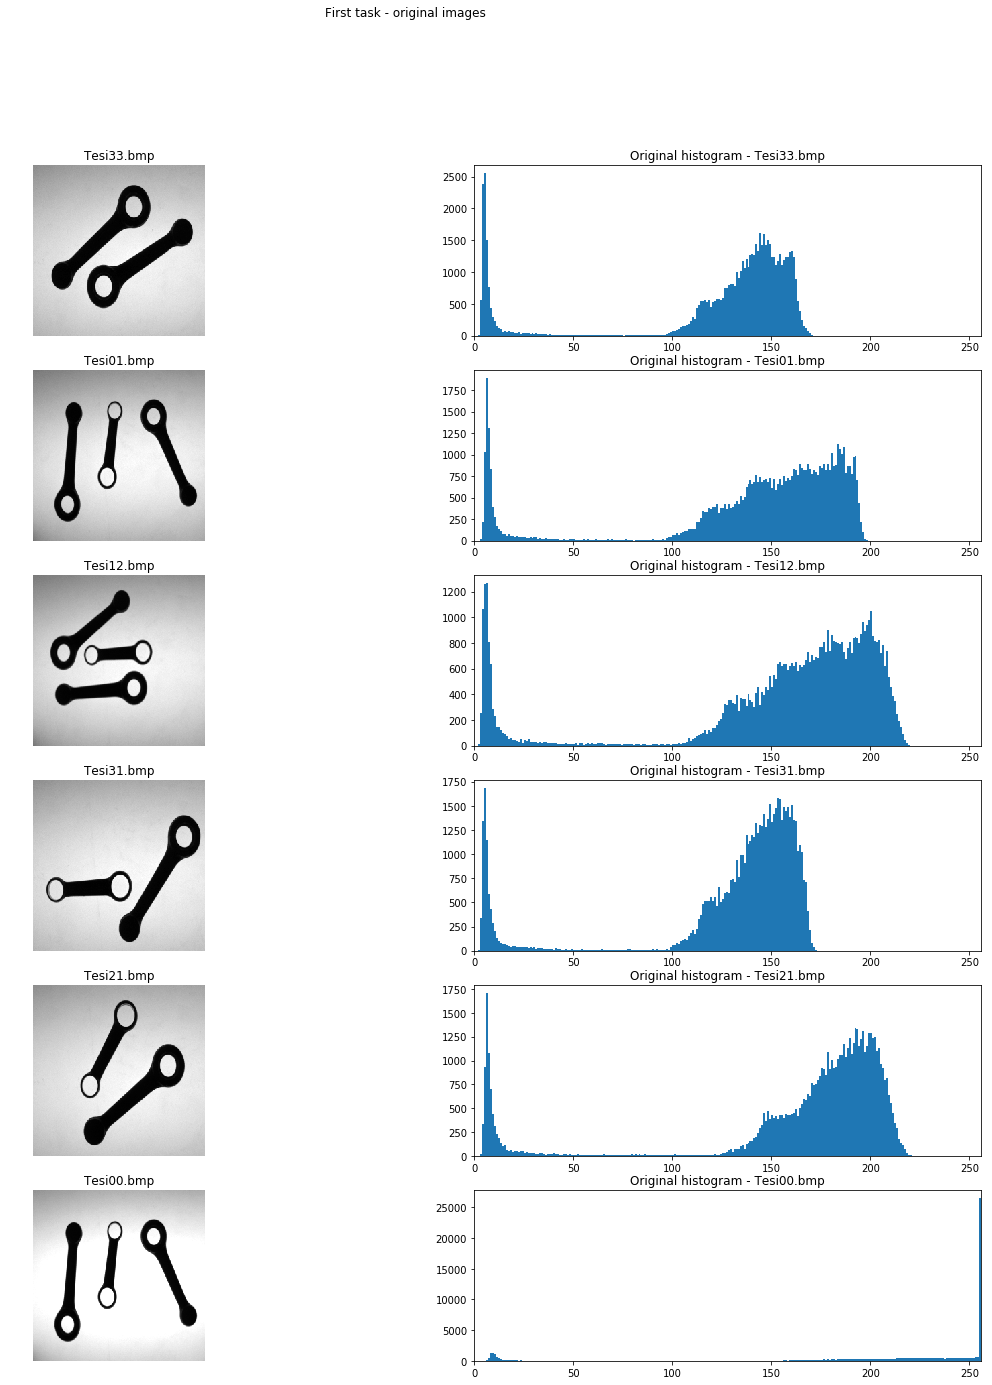

In [3]:
def image_original_analysis(task, task_name):   
    for key in task.keys():
        task[key] = {"original" : load_image(folder_path, key)}

    fig, axs = plt.subplots(nrows=len(task), ncols=2, figsize=(20, 22))
    fig.suptitle(task_name+' - original images')
    for i, key in enumerate(task.keys()):
        # plot original image
        axs[i, 0].imshow(task[key]["original"], cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 0].set_title(key)

        # plot histogram
        axs[i, 1].set_xlim([0,256])
        axs[i, 1].hist(task[key]["original"].ravel(), 256, [0, 256])
        axs[i, 1].set_title("Original histogram - " + key) 

    plt.show()
    return task

first_task = image_original_analysis(first_task, "First task")

Before thresholding, let's apply a local operator like Gaussian filter to remove noise.

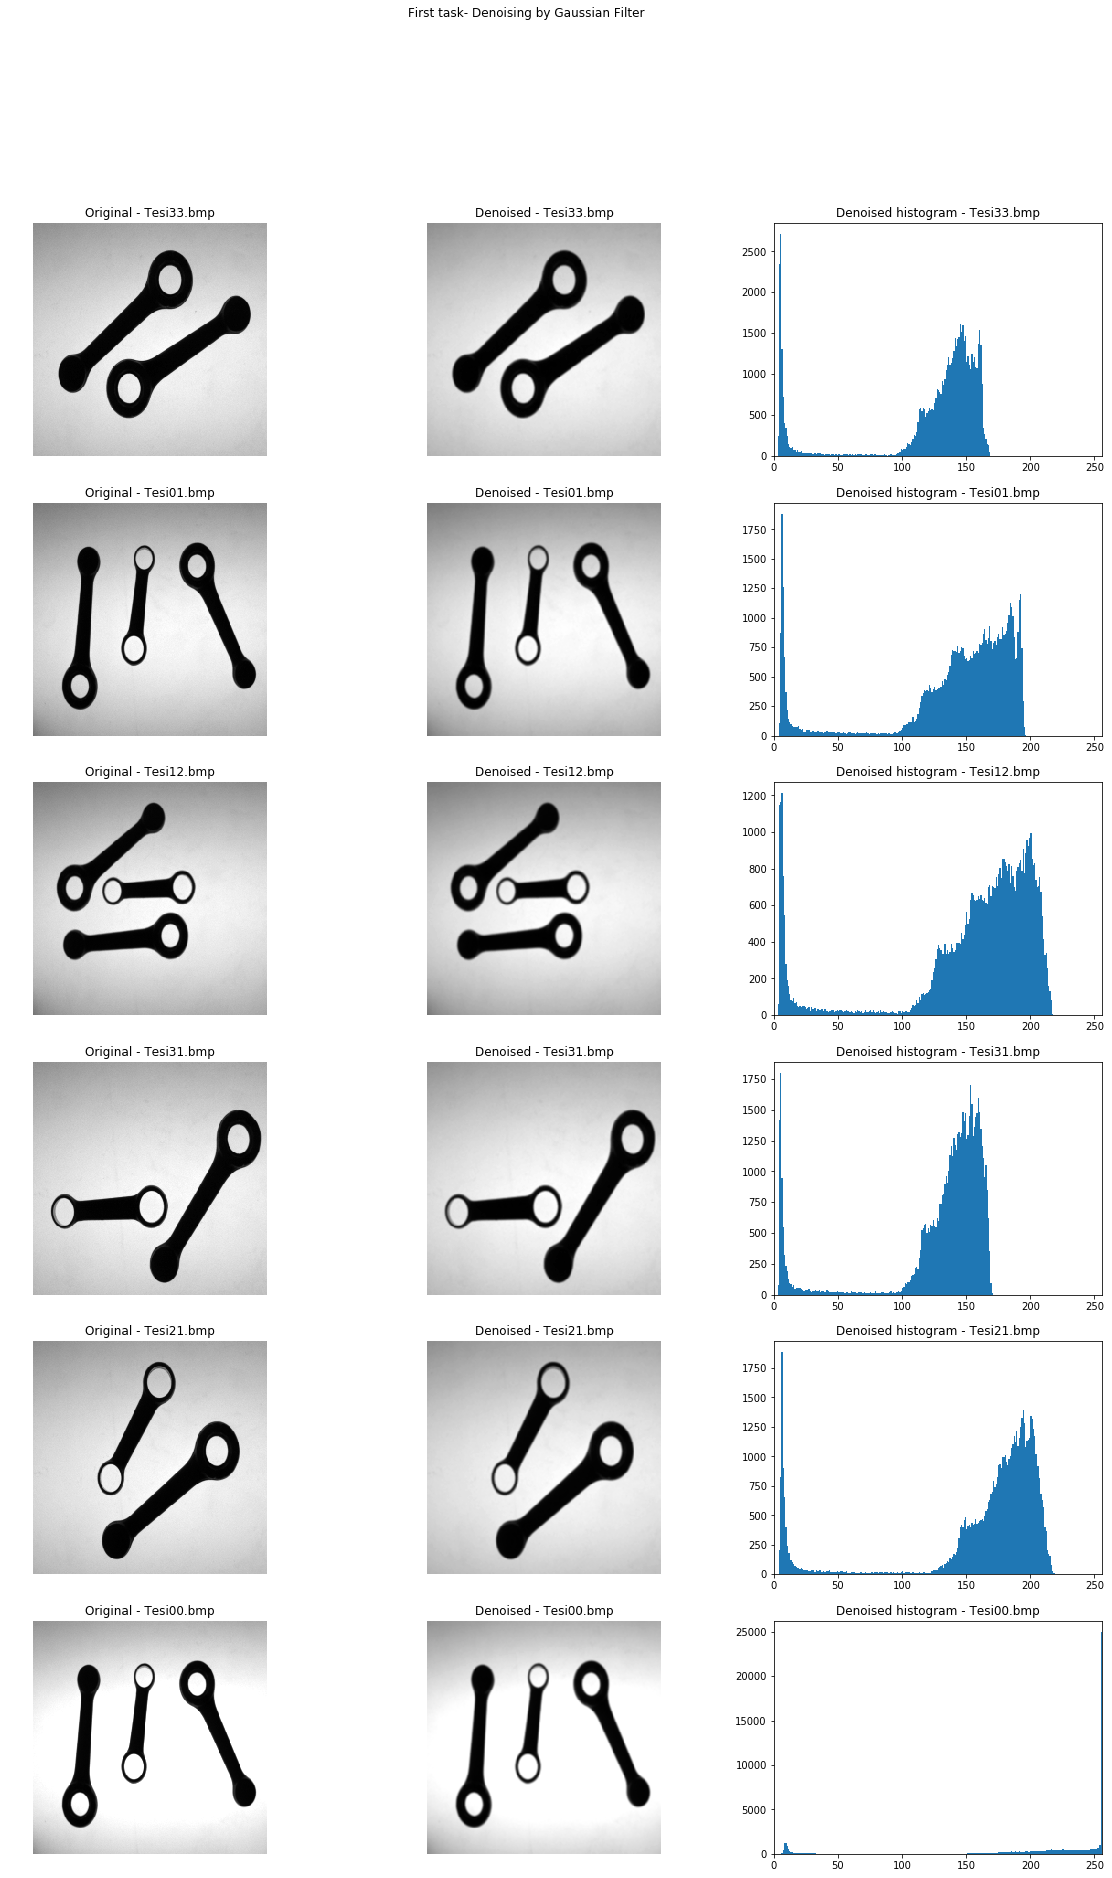

In [4]:
def image_denoising(task, task_name):

    fig, axs = plt.subplots(nrows=len(task), ncols=3, figsize=(20, 30))
    fig.suptitle(task_name+'- Denoising by Gaussian Filter')
    for i, key in enumerate(task.keys()):
        # plot original image
        axs[i, 0].imshow(task[key]["original"], cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 0].set_title("Original - " + key)

        # plot images after gaussian filter
        task[key]["denoised"] = cv2.GaussianBlur(task[key]["original"], (3, 3), 0)
        axs[i, 1].imshow( task[key]["denoised"], cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].set_title("Denoised - " + key)

        # plot histogram of images after gaussian filter
        axs[i, 2].set_xlim([0,256])
        axs[i, 2].hist( task[key]["denoised"].ravel(), 256, [0, 256])
        axs[i, 2].set_title("Denoised histogram - " + key)

    plt.show()
    return task

first_task = image_denoising(first_task, "First task")

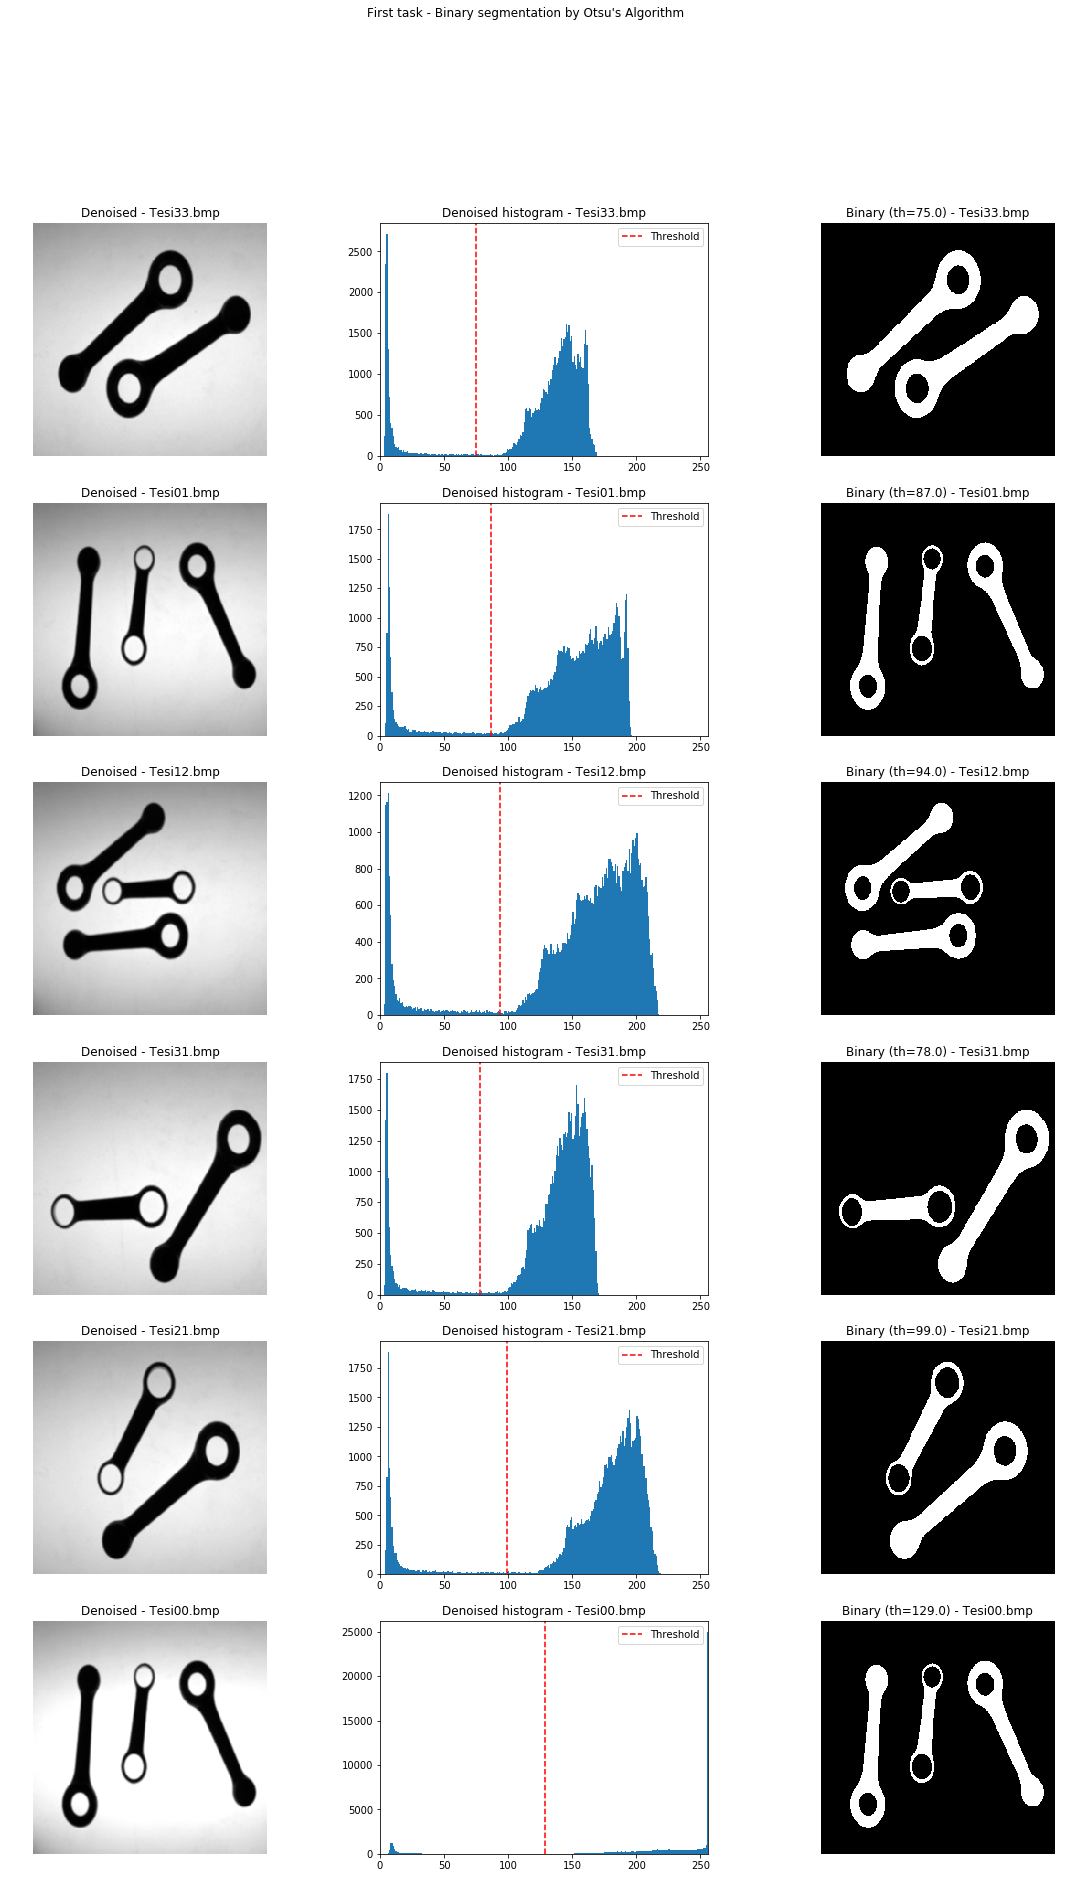

In [5]:
def image_segmentation(task, task_name):
    fig, axs = plt.subplots(nrows=len(task), ncols=3, figsize=(20, 30))
    fig.suptitle(task_name +" - Binary segmentation by Otsu's Algorithm")
    for i, key in enumerate(task.keys()):
        # plot denoised image
        axs[i, 0].imshow(task[key]["denoised"], cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 0].set_title("Denoised - " + key)

        # plot histogram of images after bilateral filter
        axs[i, 1].set_xlim([0,256])
        axs[i, 1].hist(task[key]["denoised"].ravel(), 256, [0, 256])
        axs[i, 1].set_title("Denoised histogram - " + key)

        # plot images after segmentation
        threshold, binary_img = cv2.threshold(task[key]["denoised"], 0, 255, cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
        task[key]["binary"] = binary_img
        axs[i, 1].axvline(x=threshold, color='r',linestyle='--', label='Threshold')
        axs[i, 1].legend(loc='best')
        axs[i, 2].imshow(task[key]["binary"], cmap='gray')
        axs[i, 2].axis('off')
        axs[i, 2].set_title("Binary (th="+str(threshold)+") - " + key)
    plt.show()
    return task

first_task = image_segmentation(first_task, "First task")

Then, we proceed with a connected component analysis:

In [6]:
def connected_componentets_analysis(img, connectivity=8):
    """
    Compute the number of connected components in the image

    Parameters
    ----------
    img : numpy.ndarray
        Binary image
    connectivity : int, optional
        Connectivity of the connected components. The default is 8.
    """
    n_labels, label_ids, stats, centroid = cv2.connectedComponentsWithStats(img, connectivity=connectivity)
    return n_labels, label_ids, stats, centroid


def show_blobs(n_labels, label_ids, stats, centroid, bbox_color=5):
    """
    Show the blobs in the image
    """
    output = np.zeros(label_ids.shape, dtype="uint8")
    for i in range(1, n_labels):
        # stores all the IDs of the components on the each pixel that has the same dimension as the threshold
            output[label_ids == i] = i

            # Now extract the coordinate points
            x1 = stats[i, cv2.CC_STAT_LEFT]
            y1 = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]

            # draw bounding box and centroid
            cv2.rectangle(output, (x1, y1), (x1+w, y1+h), bbox_color, 1) 
            cv2.circle(output, (int(centroid[i][0]), int(centroid[i][1])), 4, bbox_color, -1)
    return output

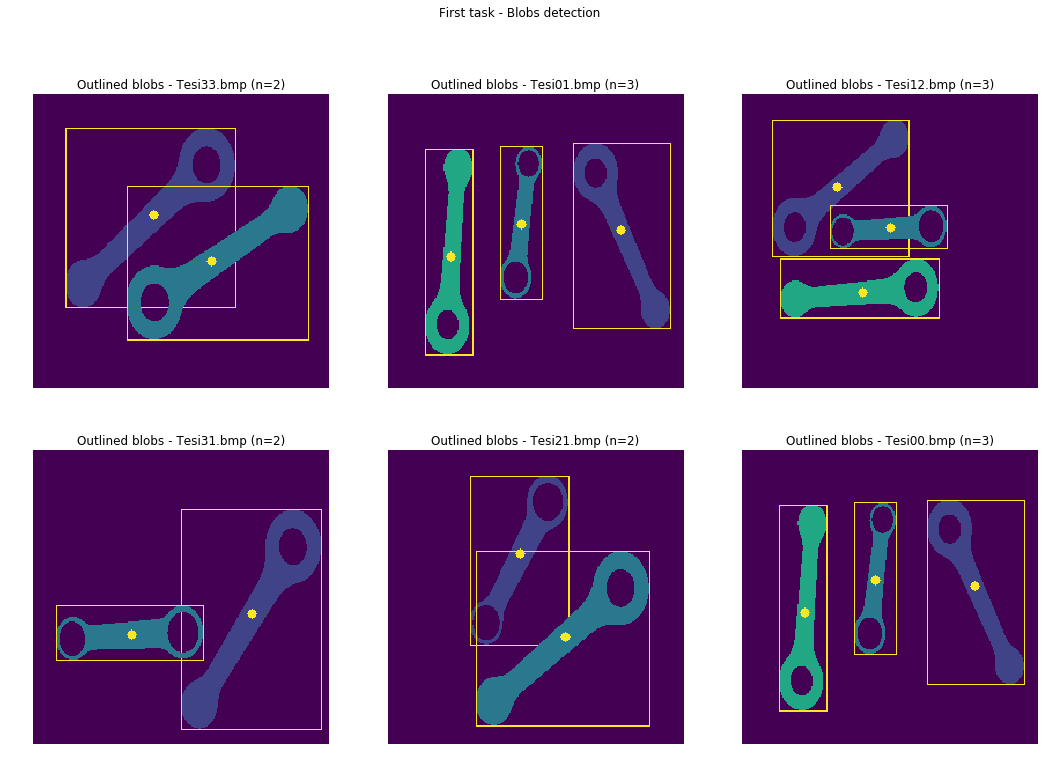

In [7]:
def image_blobs_analysis(task, task_name):    
    nrows=int(np.ceil(len(task)/3))
    ncols=3

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 12))
    fig.suptitle(task_name+" - Blobs detection")
    for n in range(nrows):
        for m in range(ncols):
            k = n*ncols + m
            if k < len(task):
                # perform connected components analysis
                key = list(task.keys())[k]
                n_labels, label_ids, stats, centroid = connected_componentets_analysis(task[key]["binary"])
                
                # store the results
                task[key]["blobs"] = {"n_labels": n_labels, "label_ids": label_ids, "stats": stats, "centroid": centroid}

                # highlight blobs
                output = show_blobs(**task[key]["blobs"])
                
                # plot connected components
                if nrows > 1:
                    axs[n, m].imshow(output)
                    axs[n, m].axis('off')
                    axs[n, m].set_title("Outlined blobs - " + key+ " (n="+str(n_labels-1)+")")
                else:
                    axs[m].imshow(output)
                    axs[m].axis('off')
                    axs[m].set_title("Outlined blobs - " + key+ " (n="+str(n_labels-1)+")")
    plt.show()
    return task

first_task = image_blobs_analysis(first_task, "First task")

For each connecting rod appearing in the image, the vision system should provide the following information:
1. Type of rod (A or B);
2. Position and orientation modulo $\pi$;
3. Length $L$, width $W$, width at the barycenter $W_b$;
4. For each hole, position of the centre and diameter size.

In [8]:
def get_blob(ids, label):
    """
    Get the blob with the given label

    Parameters
    ----------
    ids : numpy.ndarray
        Image with the labels of the connected components
    label : int
        Label of the blob to be extracted

    Returns
    -------
    numpy.ndarray
        Binary image with the blob

    """
    blob = np.zeros(ids.shape, dtype=np.uint8)
    blob[ids == label] = 1
    return blob

In [9]:
def haralick_circularity(contour, centroid):
    '''
    Compute Haralick's circularity measure
    '''
    distances = [dist.euclidean(coord, centroid) for coord in contour]
    std = np.std(distances)
    return np.mean(distances) / np.std(distances) if std > 0 else float('INF')

Image moments help you calculate some features like center of mass of the object, area of the object etc.

The function `cv2.moments()` gives a dictionary of all moment values calculated. From this moments, you can extract useful data like area, centroid etc. Centroid is given by the relations, $C_x=\frac{M_{10}}{M_{00}}$ and $C_y=\frac{M_{01}}{M_{00}}$.

In [10]:
def compute_barycentre(moments):
    """
    Compute the barycenter of a blob

    Parameters
    ----------
    moments : dict
        Moments of the blob
    
    Returns
    -------
    tuple
        Coordinates of the barycenter
    """
    cX = int(moments["m10"] / moments["m00"])
    cY = int(moments["m01"] / moments["m00"])
    return cX, cY

In [11]:
def get_holes_stats(contours, haralick_threshold=6):
    """
    For each hole in the blob, compute the position of the centre and diameter size
    """
    holes = []
    for i in range(1, len(contours)):
        # compute the barycentre of the contour
        M = cv2.moments(contours[i])
        cX, cY = compute_barycentre(M)

        # compute the area of the contour
        area = cv2.contourArea(contours[i])

        # compute haralick's circularity
        circularity_score = haralick_circularity(contours[i], (cX, cY))

        # check if the contour is circular enough
        if circularity_score > haralick_threshold:
            diameter = np.sqrt(4*area/np.pi)
            holes.append({"cX": cX, "cY": cY, "diameter": diameter})
    return holes

In [12]:
def compute_major_axis_orientation(moment):
    """
    Compute the orientation of the major axis of the blob

    Parameters
    ----------
    moment : dict
        Moments of the blob
    
    Returns
    -------
    float
        Orientation of the major axis of the blob in radiants
    """

    # compute the orientation of the blob
    theta = -0.5 * np.arctan(
        (2 * moment['mu11']) /
        (moment['mu02'] - moment['mu20'] + 1e-5)
    )

    # determine the orientation of the major axis
    # analysis of the sign of second derivative 
    second_derivative = (moment['mu02'] - moment['mu20']) * 2 * np.cos(2*theta) - 4 * moment['mu11'] * np.sin(2*theta)

    # if the second derivative is positive, we have to considere the other zero of the solution
    if second_derivative > 0:
        theta += np.pi/2

    if theta < 0:
        theta += np.pi
    return theta

In [13]:
def get_width_barycenter(barycentre, orientation, contour):
    """
    Compute the width at the barycentre of a specific blob.
    Make use of the equation of minor axis passing through the centroid of the blob
    """

    # orientation of the minor axis
    orientation_min = orientation - np.pi/2

    # exploit the equation of a line y = m*x + n 
    # where m =  tan(angle)
    # n = cY - (tan(angle) * cX ) 
    m = np.tan(orientation_min)
    n = barycentre[1] - m*barycentre[0]

    # find the two point of intersection between the line and the contour
    distances = []
    for i in range(len(contour)):
        x = contour[i][0][0]
        y = contour[i][0][1]

        # compute the distance between the contour point and the point on the line
        distances.append(np.abs(y - m*x - n))
    
    # order the distances and get the two closest points
    idxs = np.argsort(distances)
    intersections = [contour[idxs[0]][0], contour[idxs[1]][0]]

    width = dist.euclidean(intersections[0], intersections[1])
    return width, intersections

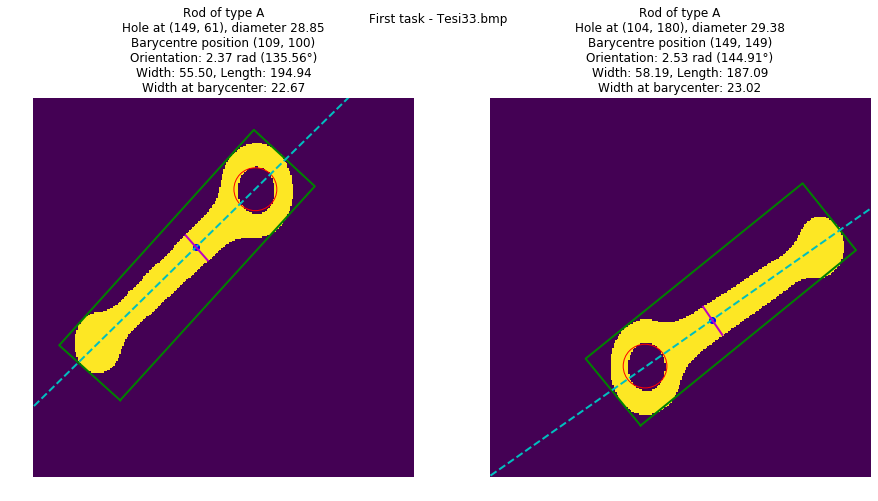

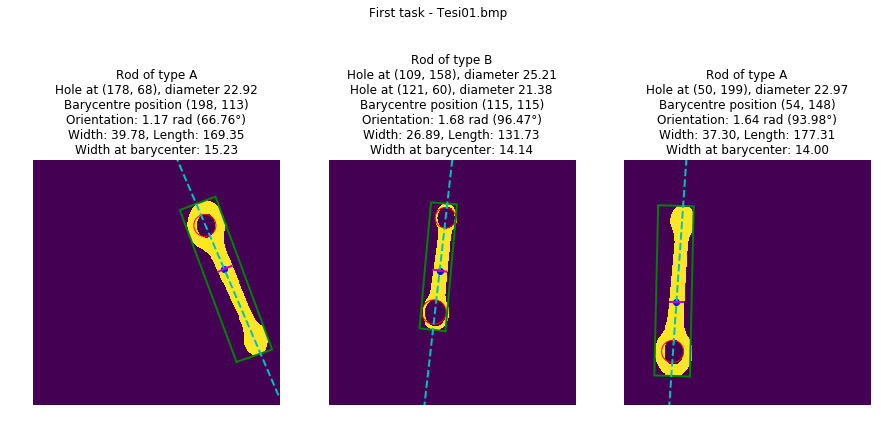

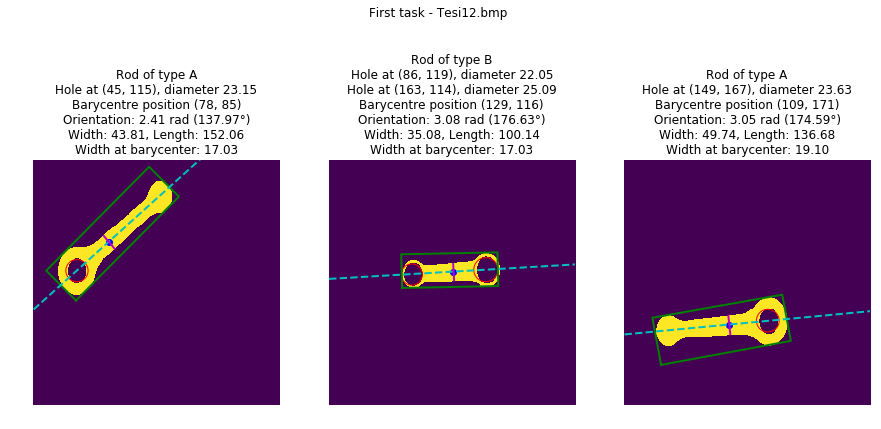

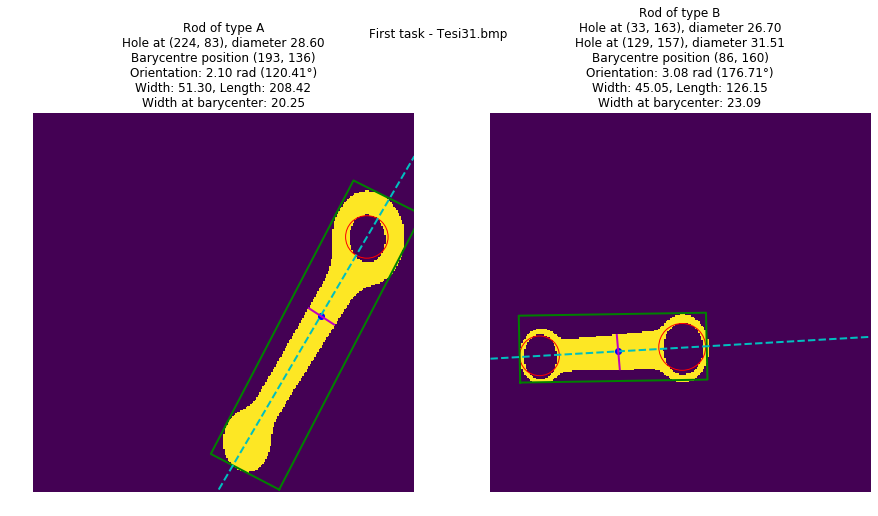

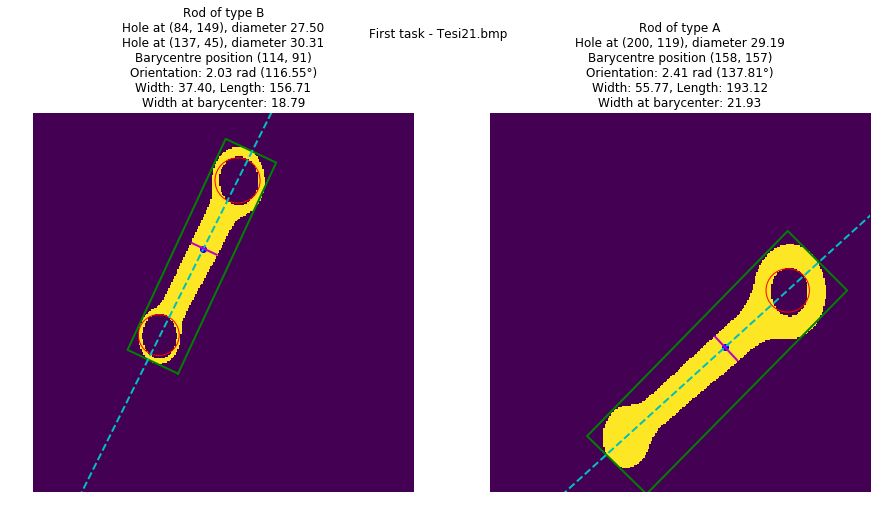

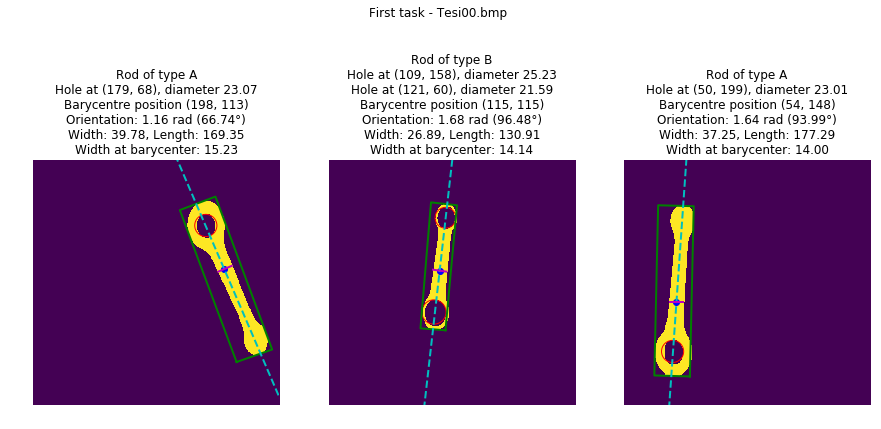

In [14]:
def image_inspection(task, task_name):
    for key in task.keys():
        n_labels = task[key]["blobs"]["n_labels"]
        labels_ids = task[key]["blobs"]["label_ids"]
        stats = task[key]["blobs"]["stats"]

        fig, axs = plt.subplots(nrows=1, ncols=n_labels-1, figsize=(15, 8))
        fig.suptitle(task_name+" - "+key)
        for i in range(1, n_labels):
            blob = get_blob(labels_ids, i)

            # find contours of the highlighted blob
            _, contours, hierarchy = cv2.findContours(blob, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

            # compute the holes to classify the type of the rod
            holes = get_holes_stats(contours)

            title = ""

            if len(holes) == 1:
                # rod is of type A
                title+="Rod of type A\n"
            elif len(holes) == 2:
                # rod is of type B
                title+="Rod of type B\n"
            else:
                # rod is unknown type
                title+="Rod of unknown type\n"

            for hole in holes:
                title+="Hole at ({:.0f}, {:.0f}), diameter {:.2f}\n".format(hole["cX"], hole["cY"], hole["diameter"])

                # plot the hole
                axs[i-1].add_patch(plt.Circle((hole["cX"], hole["cY"]), hole["diameter"]/2, color='r', fill=False))
                
            # compute the minimum enclosing rectangle
            rect = cv2.minAreaRect(contours[0])
            centroid, dimesions, rotation = rect

            moment = cv2.moments(contours[0])

            # compute the orientation of the major axis
            theta = compute_major_axis_orientation(moment)
            theta_deg = np.rad2deg(theta)

            # compute the barycenter of the blob
            cX, cY = compute_barycentre(moment)

            # compute the width at the barycenter
            width_barycenter, intersections = get_width_barycenter((cX, cY), theta, contours[0])
            
            # get the 4 corners of the rectangle
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            box = np.vstack((box, box[0]))

            # plot the barycentre
            axs[i-1].plot(cX, cY, 'bo')

            # plot  rectangle
            axs[i-1].plot(box[:,0], box[:,1], color='g', linewidth=2)            
            
            # plot the major axis
            m = np.tan(theta)
            n = cY - m*cX
            x = np.linspace(0, blob.shape[1], 100)
            y = m*x + n
            axs[i-1].plot(x, y, color='c', linestyle="--", linewidth=2)

            # plot the width at the barycenter
            axs[i-1].plot([intersections[0][0], intersections[1][0]], [intersections[0][1], intersections[1][1]], color='m', linewidth=2)

            length = np.max(dimesions)
            width = np.min(dimesions)

            # print stats on the title
            title+="Barycentre position ({:.0f}, {:.0f})\n".format(cX, cY)
            title+="Orientation: {:.2f} rad ({:.2f}°)\n".format(theta, theta_deg)
            title+="Width: {:.2f}, Length: {:.2f}\n".format(width, length)
            title+="Width at barycenter: {:.2f}".format(width_barycenter)

            # plot the blob
            axs[i-1].imshow(blob)
            axs[i-1].axis('off')
            axs[i-1].set_title(title)
        
        plt.show()

image_inspection(first_task, "First task")

## Second Task
While still meeting the requirement of the First Task, the system is modified in order to deal with the following change in the characteristics of the working images:
- The inspection area may be dirty due to the presence of scattered iron powder.

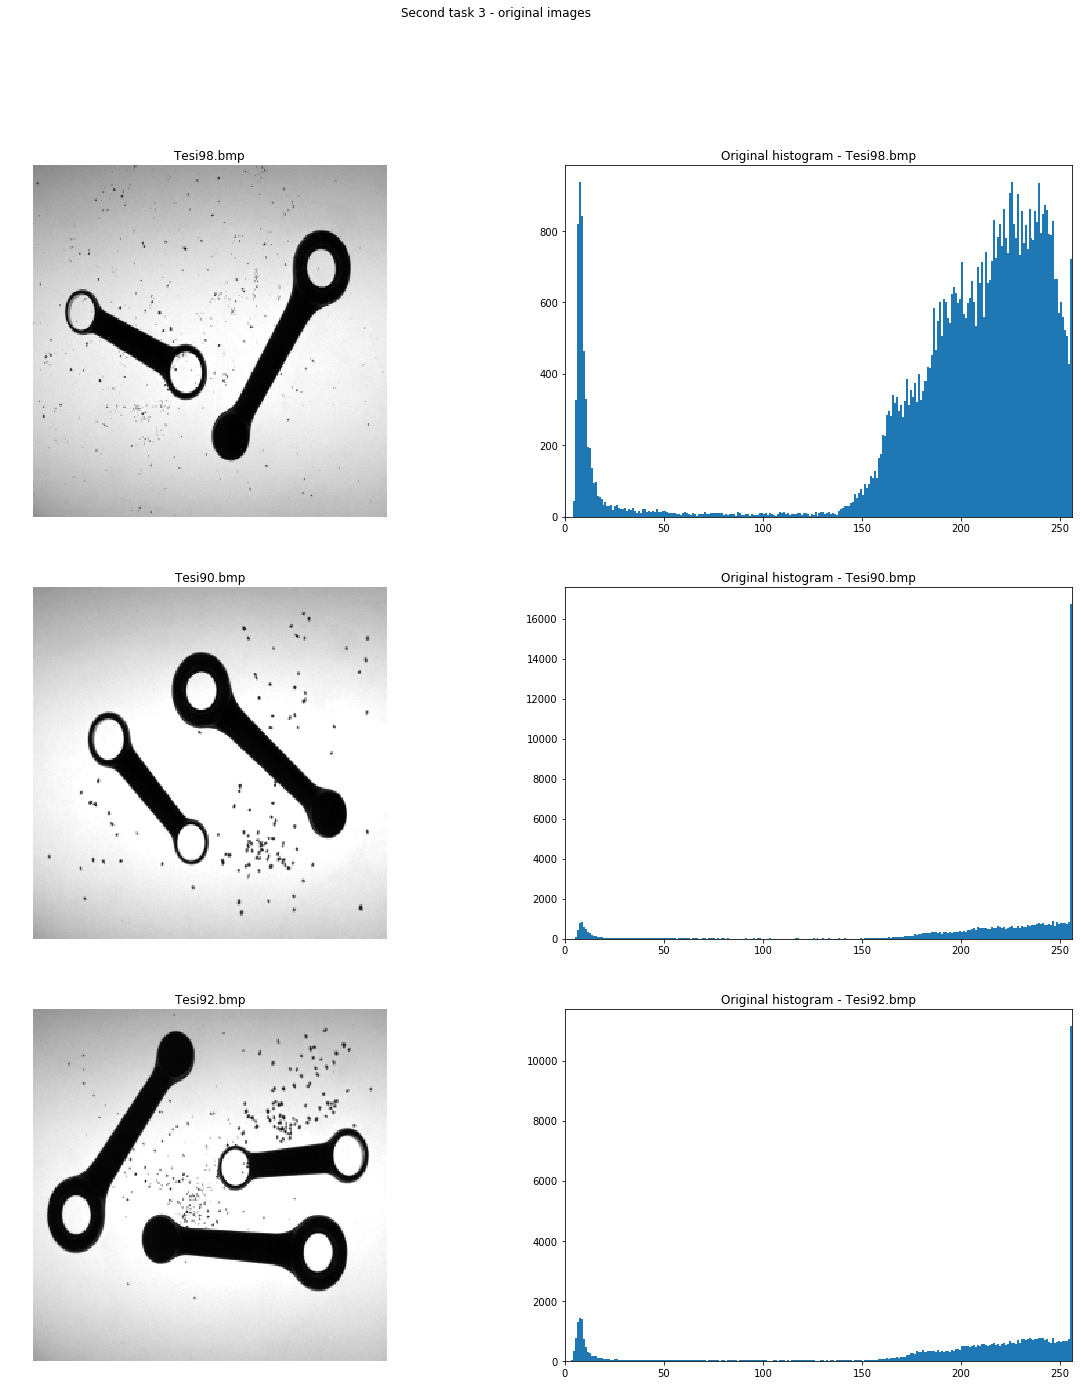

In [15]:
second_task_3 = image_original_analysis(second_task_3, "Second task 3")

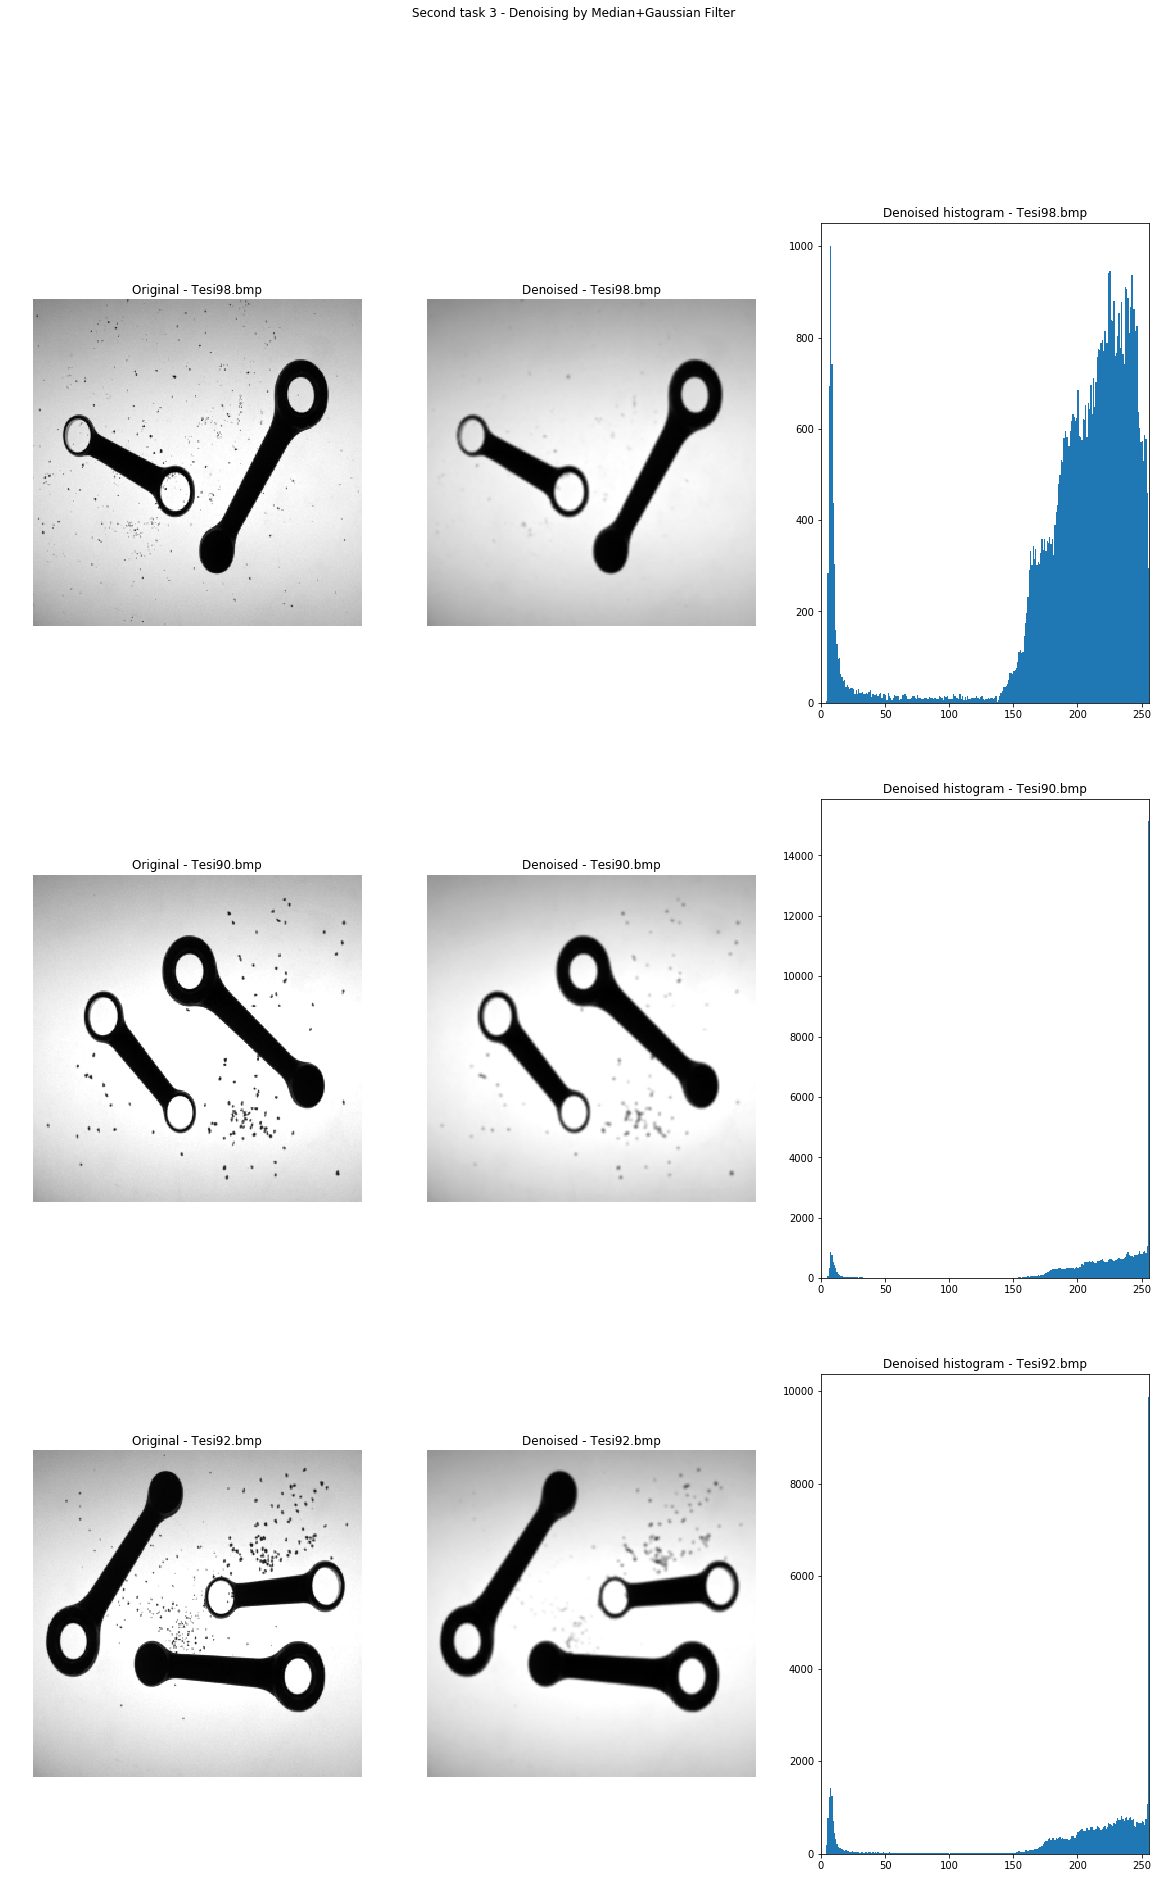

In [16]:
def image_denoising(task, task_name):

    fig, axs = plt.subplots(nrows=len(task), ncols=3, figsize=(20, 30))
    fig.suptitle(task_name+' - Denoising by Median+Gaussian Filter')
    for i, key in enumerate(task.keys()):
        # plot original image
        axs[i, 0].imshow(task[key]["original"], cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 0].set_title("Original - " + key)

        # plot images after median and gaussian filter
        task[key]["denoised"] = cv2.medianBlur(task[key]["original"], 3)
        task[key]["denoised"] = cv2.GaussianBlur(task[key]["denoised"], (3, 3), 0)
        axs[i, 1].imshow( task[key]["denoised"], cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].set_title("Denoised - " + key)

        # plot histogram of images after gaussian filter
        axs[i, 2].set_xlim([0,256])
        axs[i, 2].hist( task[key]["denoised"].ravel(), 256, [0, 256])
        axs[i, 2].set_title("Denoised histogram - " + key)

    plt.show()
    return task

second_task_3 = image_denoising(second_task_3, "Second task 3")

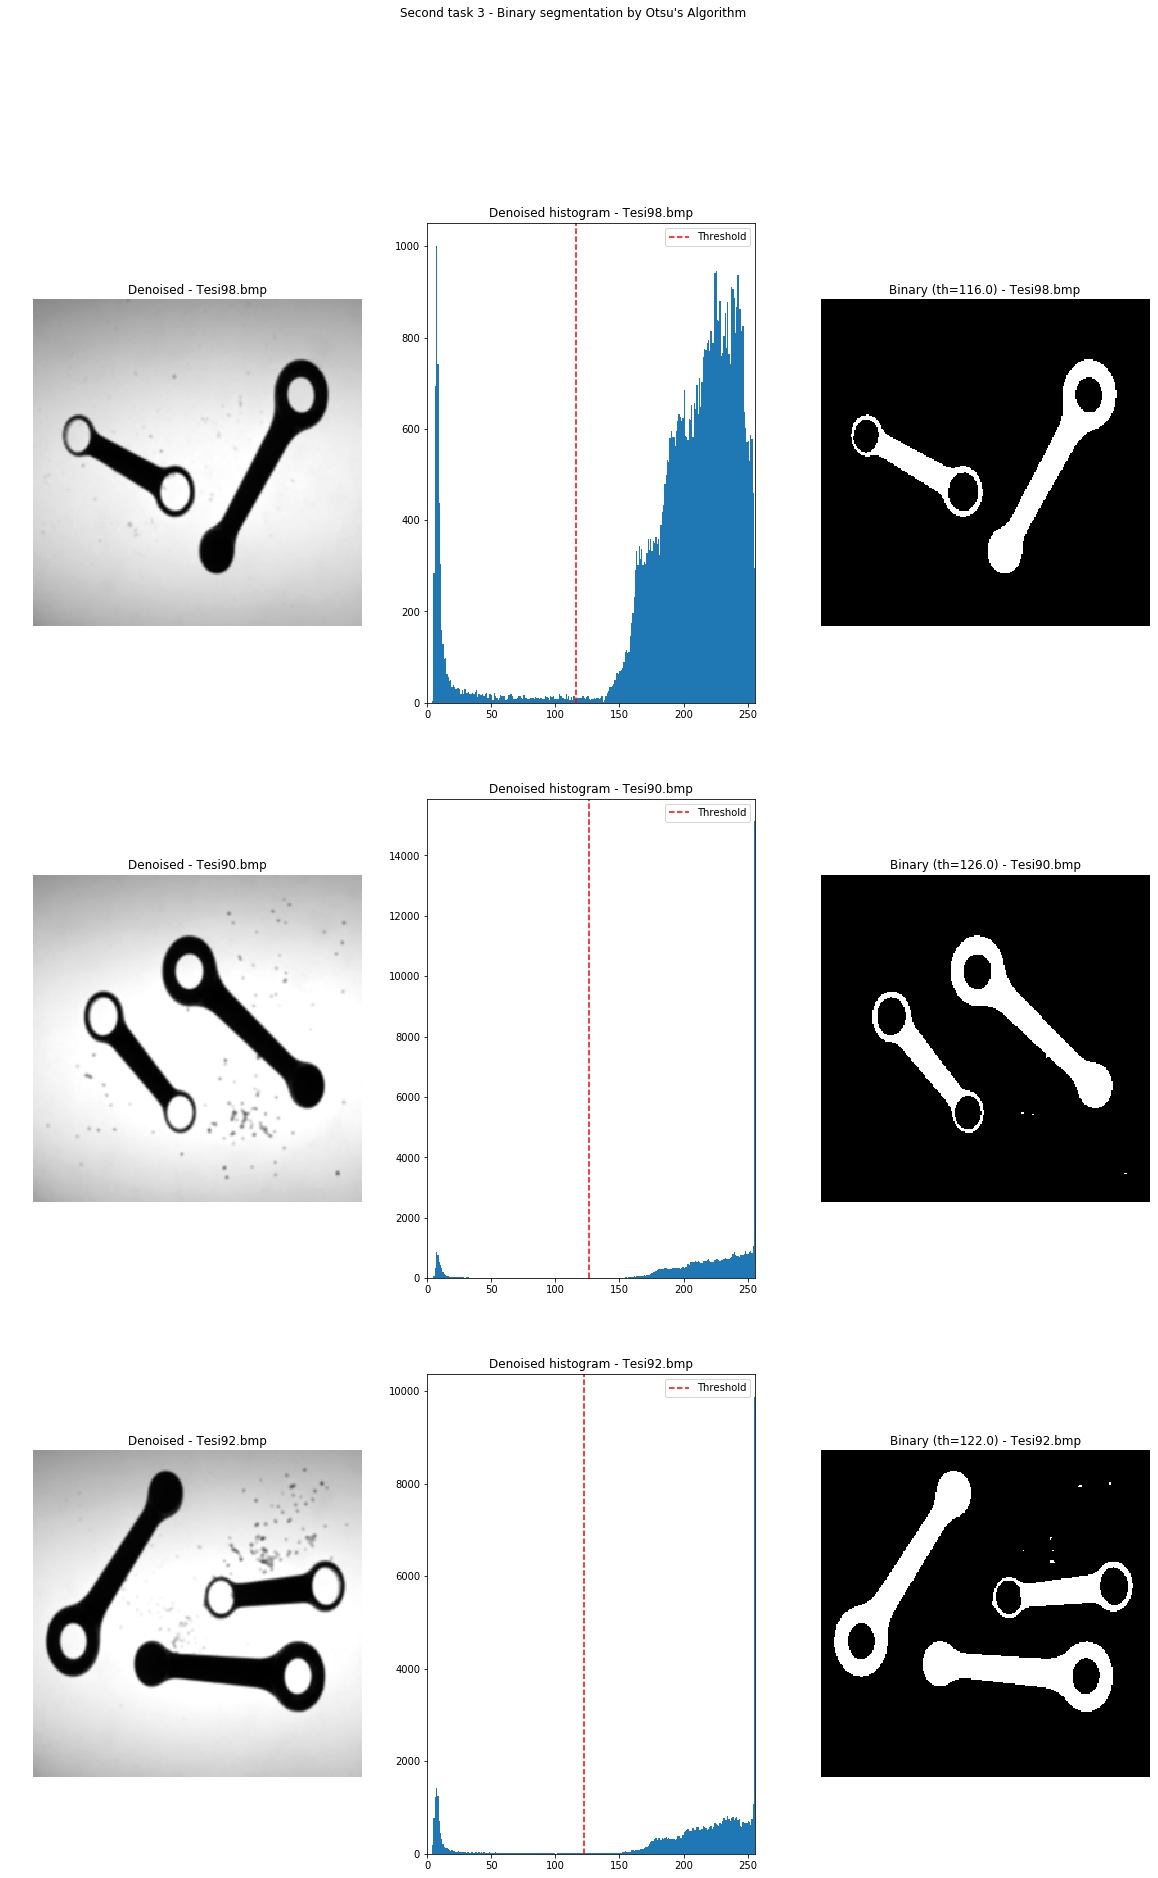

In [17]:
second_task_3 = image_segmentation(second_task_3, "Second task 3")

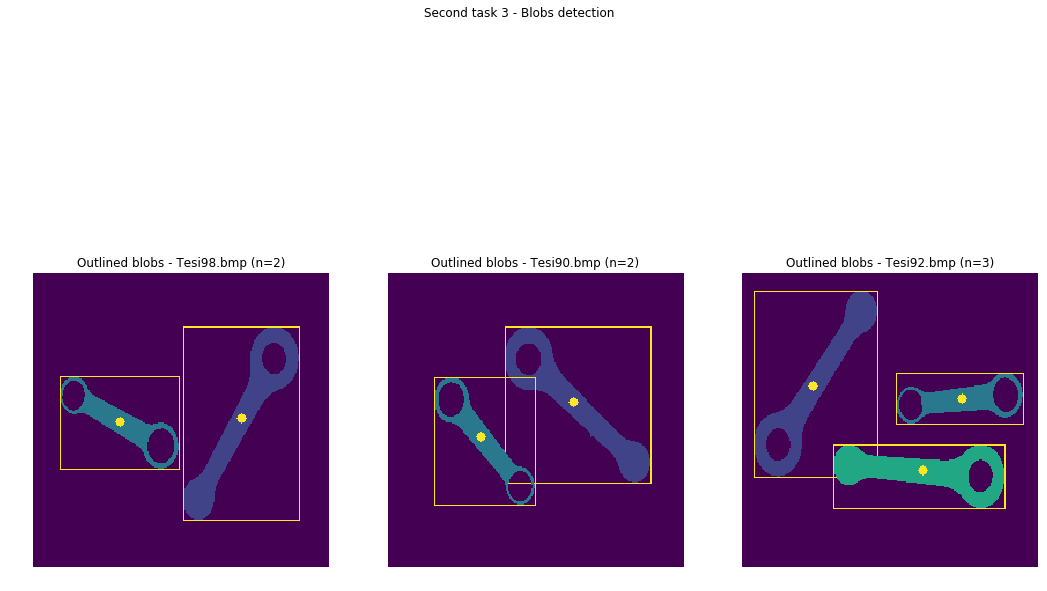

In [18]:
def connected_componentets_analysis(img, connectivity=8, area_threshold=100):
    """
    Compute the number of connected components in the image

    Parameters
    ----------
    img : numpy.ndarray
        Binary image
    connectivity : int, optional
        Connectivity of the connected components. The default is 8.
    area_threshold : int, optional
        Area threshold to filter connected components. The default is 100.
    """
    n_labels, label_ids, stats, centroid = cv2.connectedComponentsWithStats(img, connectivity=connectivity)

    idx_thresh = np.where(stats[:, cv2.CC_STAT_AREA] > area_threshold)[0] 
    stats = stats[idx_thresh]
    centroid = centroid[idx_thresh]
    n_labels = len(stats)

    # keep only the connected components with area greater than the threshold, all the others are set to background
    inds = label_ids == idx_thresh[:, None, None]
    label_ids[~np.any(inds, axis = 0)] = 0

    # shrink the label ids to the range [0, n_labels-1]
    for value, i in enumerate(idx_thresh):
        label_ids[label_ids == i] = value
            
    return n_labels, label_ids, stats, centroid

second_task_3 = image_blobs_analysis(second_task_3, "Second task 3")

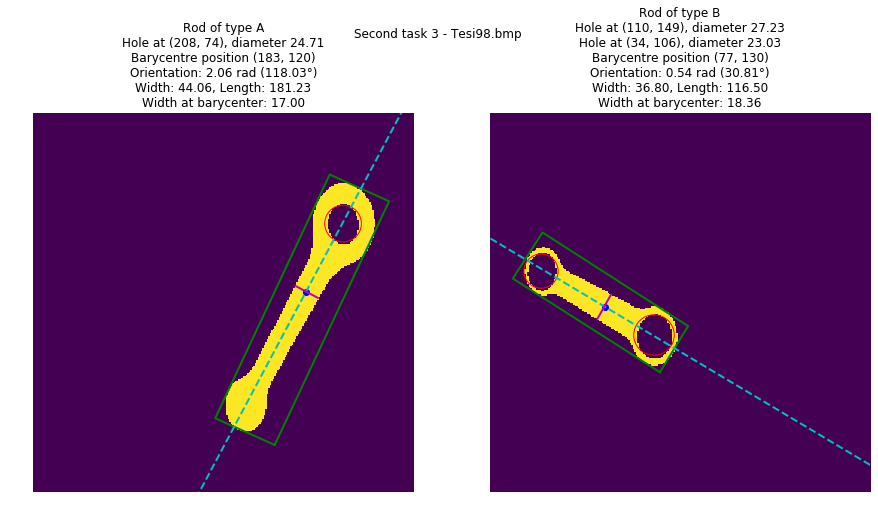

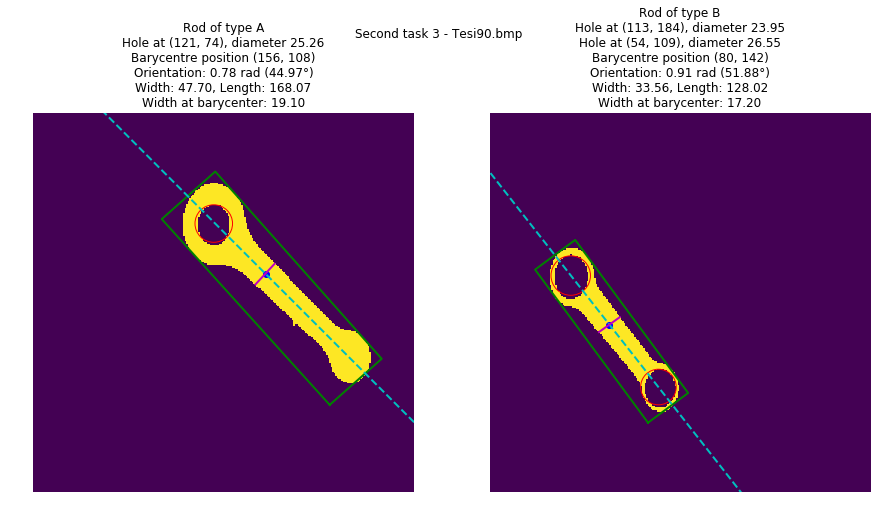

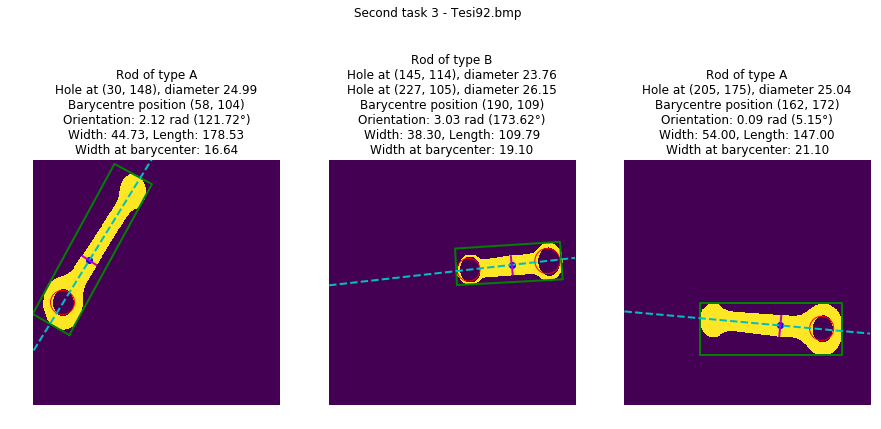

In [19]:
image_inspection(second_task_3, "Second task 3")